In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Seat.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Altea,Seri_Arosa,Seri_Cordoba,...,Model_2.0 SXE,Model_2.0 TDI Stylance,Model_2.0 TFSI Cupra,Model_2.0 TSI Cupra,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,788000,0.454545,0.222222,0.182692,-0.749064,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,610000,0.636364,-0.194444,0.182692,0.202247,3.0,0.0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,285000,-0.454545,-0.472222,-0.817308,0.299625,9.0,0.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,649000,0.636364,-0.194444,-2.697115,-0.644592,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,625000,0.363636,0.083333,0.182692,0.411985,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_5076\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,53680.656565,3.808714e+09,61714.778467,40568.802019


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:28:21,728] A new study created in memory with name: no-name-9667a89d-ce2b-4a59-8a1d-dad9374dc5bf
[I 2023-05-23 21:28:21,910] Trial 2 finished with value: 344159.10916679545 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.056980186464482635, 'max_depth': 11, 'min_child_weight': 253}. Best is trial 2 with value: 344159.10916679545.
[I 2023-05-23 21:28:21,916] Trial 0 finished with value: 548038.0031924661 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.0002621758954277165, 'max_depth': 9, 'min_child_weight': 84}. Best is trial 2 with value: 344159.10916679545.
[I 2023-05-23 21:28:21,930] Trial 1 finished with value: 483832.4174733861 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.013285916494896301, 'max_depth': 7, 'min_child_weight': 130}. Best is trial 2 with value: 344159.10916679545.
[I 2023-05-23 21:28:21,956] Trial 3 finished with value: 200940.03106102033 and parameters: 

[I 2023-05-23 21:28:23,059] Trial 28 finished with value: 195221.49491069367 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.11220683511355897, 'max_depth': 4, 'min_child_weight': 40}. Best is trial 27 with value: 63652.28365471823.
[I 2023-05-23 21:28:23,070] Trial 31 finished with value: 227957.00668134412 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.09444886281189716, 'max_depth': 4, 'min_child_weight': 46}. Best is trial 27 with value: 63652.28365471823.
[I 2023-05-23 21:28:23,184] Trial 32 finished with value: 243229.9404905316 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.08742068418628701, 'max_depth': 15, 'min_child_weight': 48}. Best is trial 27 with value: 63652.28365471823.
[I 2023-05-23 21:28:23,247] Trial 33 finished with value: 224593.38531236438 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.09565910366991948, 'max_depth': 15, 'min_child_weigh

[I 2023-05-23 21:28:24,653] Trial 60 finished with value: 68320.42665471771 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.44788214609709615, 'max_depth': 3, 'min_child_weight': 2}. Best is trial 27 with value: 63652.28365471823.
[I 2023-05-23 21:28:24,731] Trial 61 finished with value: 66995.8198788033 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.4855193907098357, 'max_depth': 3, 'min_child_weight': 3}. Best is trial 27 with value: 63652.28365471823.
[I 2023-05-23 21:28:24,839] Trial 63 finished with value: 67065.73822031618 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.44848168405134375, 'max_depth': 10, 'min_child_weight': 30}. Best is trial 27 with value: 63652.28365471823.
[I 2023-05-23 21:28:24,863] Trial 65 finished with value: 142595.93747475112 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.14484276716127642, 'max_depth': 3, 'min_child_weight': 59}

[I 2023-05-23 21:28:26,682] Trial 90 finished with value: 67324.66011224948 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.39174907879626814, 'max_depth': 7, 'min_child_weight': 2}. Best is trial 27 with value: 63652.28365471823.
[I 2023-05-23 21:28:26,921] Trial 92 finished with value: 62495.10042405101 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.40323427786563015, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 92 with value: 62495.10042405101.
[I 2023-05-23 21:28:26,972] Trial 91 finished with value: 65325.74728031728 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.39462808095697777, 'max_depth': 10, 'min_child_weight': 3}. Best is trial 92 with value: 62495.10042405101.
[I 2023-05-23 21:28:27,014] Trial 94 finished with value: 97286.11102271228 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3061876618051785, 'max_depth': 4, 'min_child_weight': 250}

[I 2023-05-23 21:28:28,586] Trial 120 finished with value: 70535.48006707916 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.4959422594265902, 'max_depth': 6, 'min_child_weight': 48}. Best is trial 92 with value: 62495.10042405101.
[I 2023-05-23 21:28:28,674] Trial 121 finished with value: 65258.40854775695 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.44028800720781935, 'max_depth': 6, 'min_child_weight': 8}. Best is trial 92 with value: 62495.10042405101.
[I 2023-05-23 21:28:28,740] Trial 122 finished with value: 64849.99940621022 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.4070650473225947, 'max_depth': 6, 'min_child_weight': 8}. Best is trial 92 with value: 62495.10042405101.
[I 2023-05-23 21:28:28,880] Trial 123 finished with value: 66966.58858132055 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.4961031808537332, 'max_depth': 12, 'min_child_weight': 8

[I 2023-05-23 21:28:30,556] Trial 149 finished with value: 68784.9549521852 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.425740877529536, 'max_depth': 3, 'min_child_weight': 15}. Best is trial 92 with value: 62495.10042405101.
[I 2023-05-23 21:28:30,584] Trial 151 finished with value: 69424.44674534794 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.42869869274887457, 'max_depth': 3, 'min_child_weight': 16}. Best is trial 92 with value: 62495.10042405101.
[I 2023-05-23 21:28:30,604] Trial 152 finished with value: 69132.45477333406 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.4242361638227227, 'max_depth': 3, 'min_child_weight': 15}. Best is trial 92 with value: 62495.10042405101.
[I 2023-05-23 21:28:30,652] Trial 153 finished with value: 71442.16913650253 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.3561720462074727, 'max_depth': 3, 'min_child_weight': 15

[I 2023-05-23 21:28:32,426] Trial 180 finished with value: 64373.5145792627 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.41150010469734916, 'max_depth': 5, 'min_child_weight': 12}. Best is trial 92 with value: 62495.10042405101.
[I 2023-05-23 21:28:32,505] Trial 181 finished with value: 75140.85028144866 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.39162348032960576, 'max_depth': 5, 'min_child_weight': 118}. Best is trial 92 with value: 62495.10042405101.
[I 2023-05-23 21:28:32,627] Trial 182 finished with value: 63629.600913040675 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4084359236672439, 'max_depth': 5, 'min_child_weight': 9}. Best is trial 92 with value: 62495.10042405101.
[I 2023-05-23 21:28:32,658] Trial 184 finished with value: 78406.3125153963 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3293483404140311, 'max_depth': 5, 'min_child_weight': 

[I 2023-05-23 21:28:34,548] Trial 209 finished with value: 62208.61954649778 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.4036116527806685, 'max_depth': 5, 'min_child_weight': 6}. Best is trial 208 with value: 61915.25586474183.
[I 2023-05-23 21:28:34,640] Trial 212 finished with value: 65419.120505752115 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3797714141581088, 'max_depth': 5, 'min_child_weight': 18}. Best is trial 208 with value: 61915.25586474183.
[I 2023-05-23 21:28:34,708] Trial 211 finished with value: 64256.21662826997 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.38667138309135857, 'max_depth': 5, 'min_child_weight': 18}. Best is trial 208 with value: 61915.25586474183.
[I 2023-05-23 21:28:34,761] Trial 213 finished with value: 65087.77238158523 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3709605201707723, 'max_depth': 5, 'min_child_weight

[I 2023-05-23 21:28:36,935] Trial 239 finished with value: 63541.57293593029 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.35761209464990157, 'max_depth': 5, 'min_child_weight': 11}. Best is trial 208 with value: 61915.25586474183.
[I 2023-05-23 21:28:36,983] Trial 242 finished with value: 63527.88033849231 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3616152959363714, 'max_depth': 5, 'min_child_weight': 11}. Best is trial 208 with value: 61915.25586474183.
[I 2023-05-23 21:28:36,985] Trial 241 finished with value: 63548.62057464124 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.35722607209182167, 'max_depth': 5, 'min_child_weight': 11}. Best is trial 208 with value: 61915.25586474183.
[I 2023-05-23 21:28:37,043] Trial 243 finished with value: 64488.69059654448 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.343807590871922, 'max_depth': 5, 'min_child_weight

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 61915.2559
Best params:
	colsample_bytree: 0.9
	subsample: 1.0
	learning_rate: 0.39388144341459197
	max_depth: 5
	min_child_weight: 1


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.3],
                  "max_depth": [5,9],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.9],
               'subsample': [1],
               'min_child_weight': [5]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 1}
{'TestDeger': 53211.99814994098, 'MSE': 3987022623.008158, 'RMSE': 63142.87468121924, 'MAE': 41494.81508282104}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9180459620463901

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9048528154181146

In [17]:
marka_model = joblib.dump(grid_final_model, "Seat.pkl")

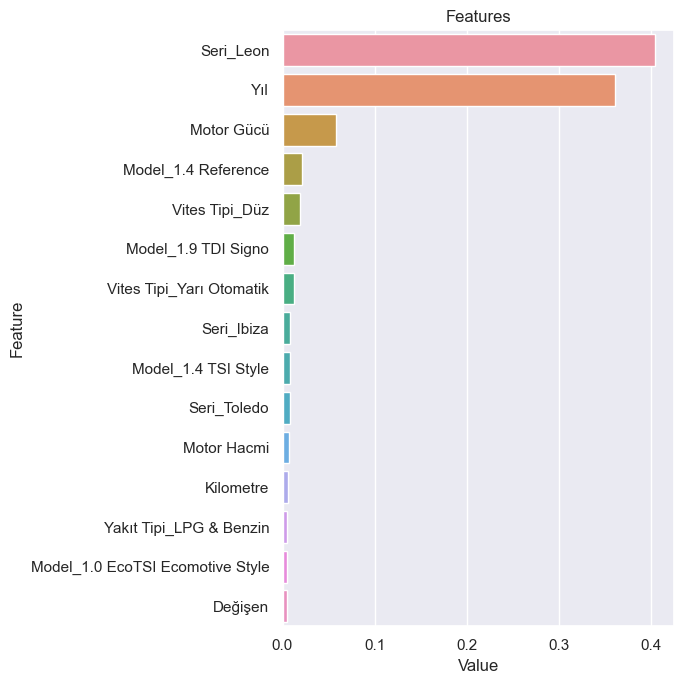

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)